In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=1
os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=1
os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=1
os.environ["VECLIB_MAXIMUM_THREADS"] = "1" # export VECLIB_MAXIMUM_THREADS=1
os.environ["NUMEXPR_NUM_THREADS"] = "1" # export NUMEXPR_NUM_THREADS=1
os.environ["CUDA_VISIBLE_DEVICES"]= '3'

import numpy as np
import matplotlib.pyplot as plt
import multielec_src.fitting as fitting
import multielec_src.multielec_utils as mutils
from scipy.io import loadmat
import multiprocessing as mp
import statsmodels.api as sm
from copy import deepcopy, copy
import visionloader as vl
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
%load_ext autoreload
%autoreload 2

3 2
6 2


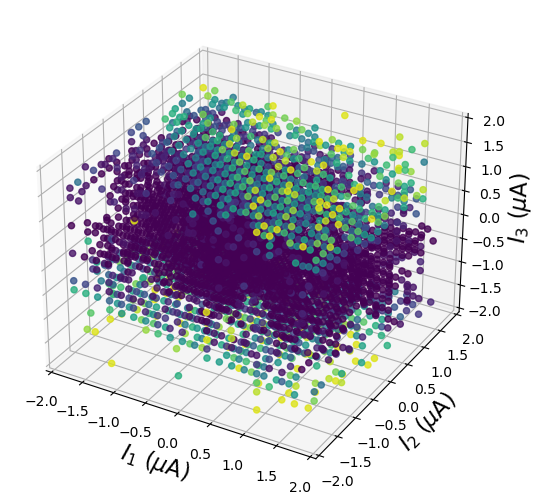

[[-7.96728285 -1.61424535 -1.36291061 -6.52922199]
 [-8.68868324  1.58200936  1.32983457  5.78956787]]


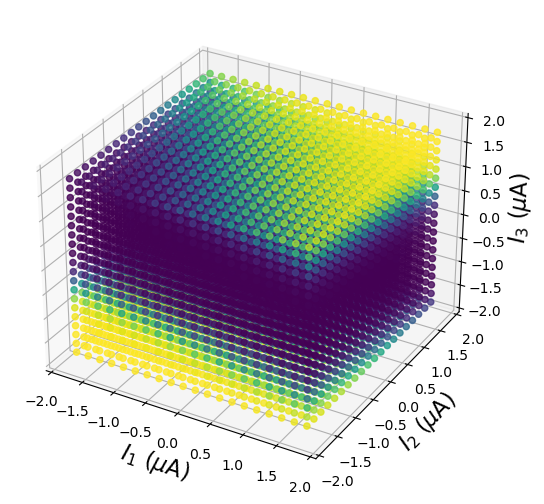

11 2


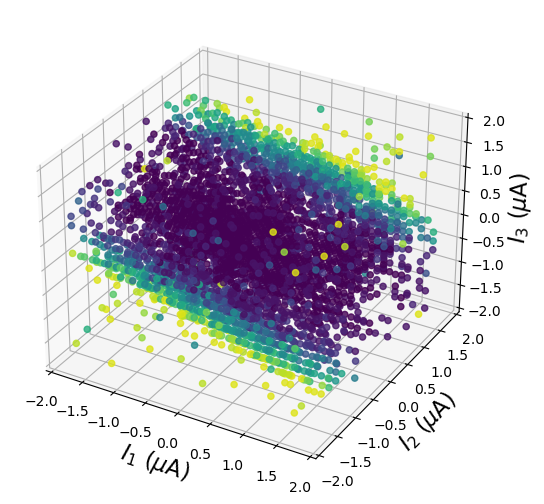

[[-5.33209373  0.74892679  2.59586813  2.53772721]
 [-5.34071609 -1.06995467 -2.8813666  -2.88566928]]


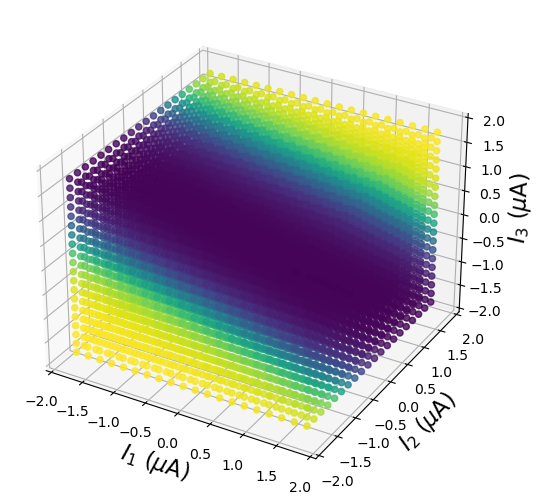

12 2


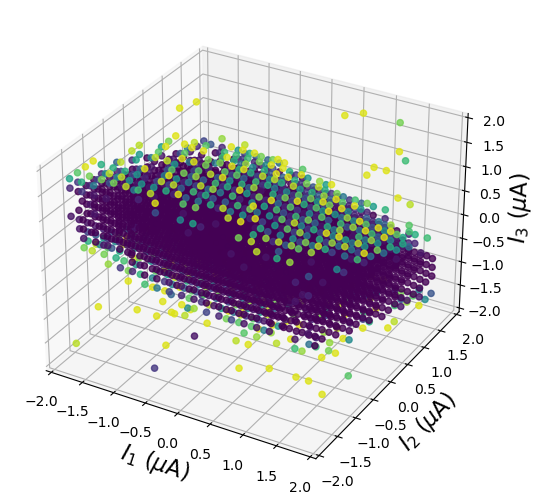

[[ -8.84980418  -2.50622377  -4.38516037 -11.68062242]
 [-18.73411656  -2.9383727    3.74037462  11.56192964]
 [-13.39808329   3.77583519   6.12032798  14.52929139]]


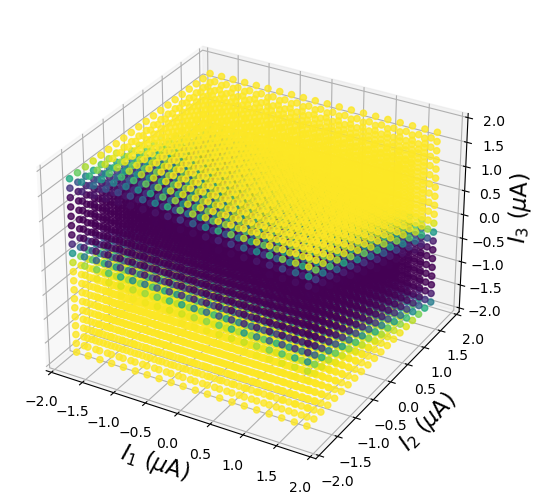

14 2


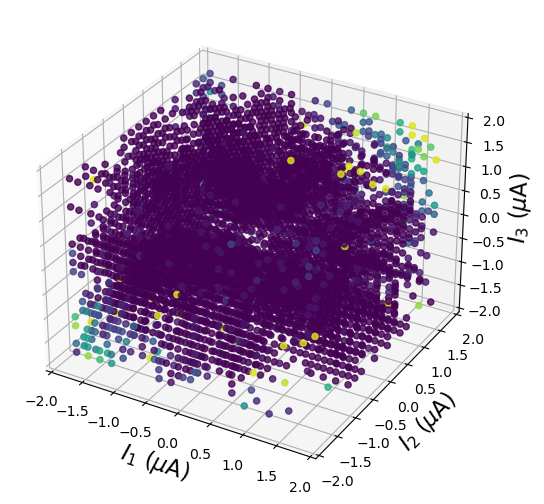

[[-23.47959017 -10.52452448   2.74904737  -1.17526417]
 [ -6.95303332  -0.44930605  -2.05846842  -1.22678775]
 [ -7.90832085   1.78700902   2.05619013   1.36532048]]


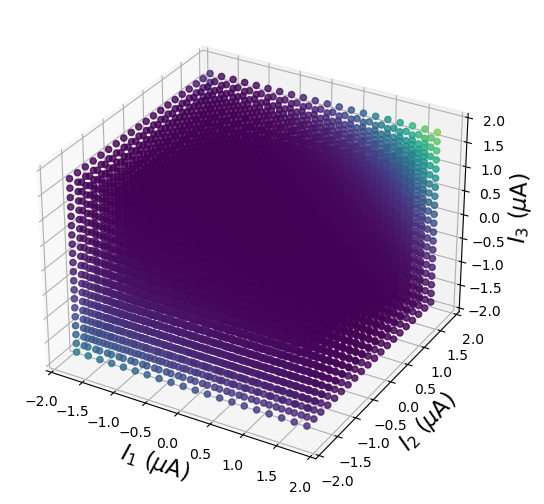

72 3


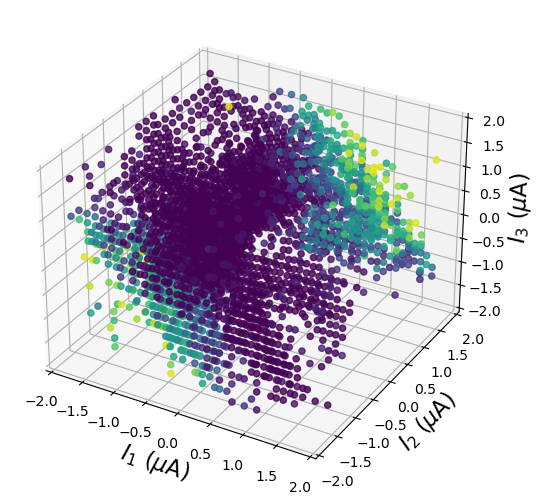

[[-7.21732216  3.14592854  2.02954125  2.34375975]
 [-7.54132793 -3.3341854  -2.11915795 -2.70765771]]


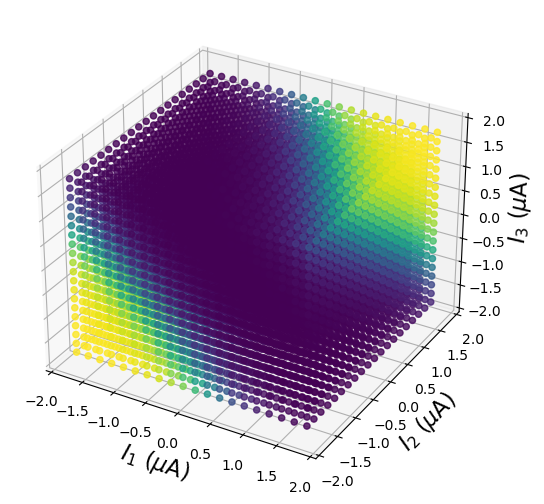

74 3


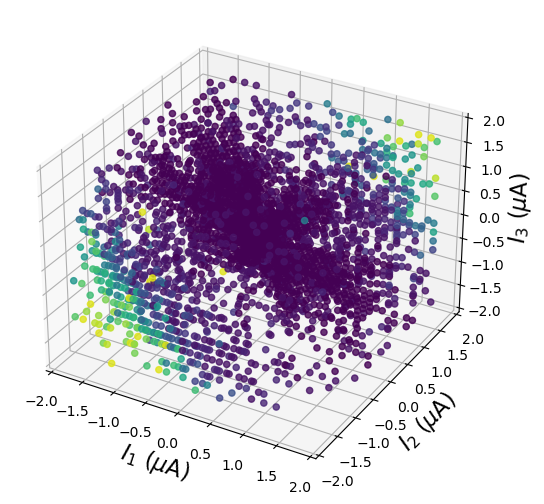

[[-5.62409522 -1.62576491 -1.98707604 -1.09865249]
 [-6.23194421  1.40781923  2.01383848  1.07555239]]


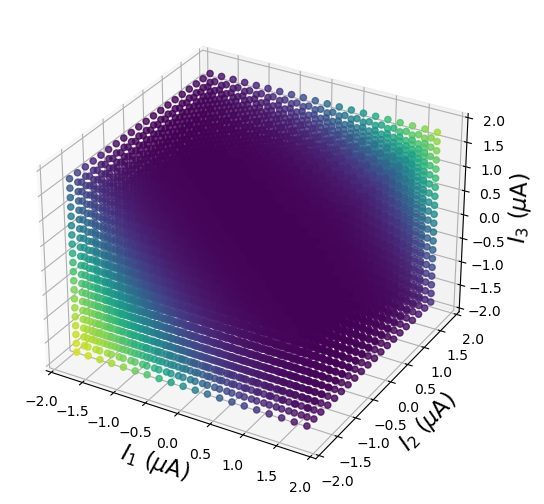

75 3


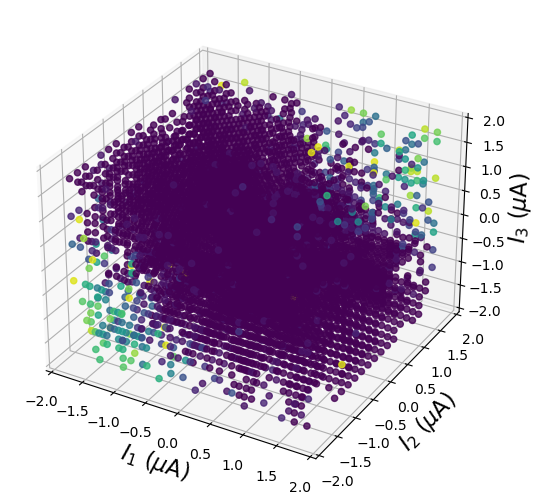

/Volumes/Lab/Users/praful/multielectrode/multielec_src/fitting.py:291: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))


[[-10.43261755   1.94352713  -1.33095683  -1.02705156]
 [ -9.09536419  -2.43992575  -2.74010544  -1.61332898]
 [ -7.52142087   1.77804962   1.93446713   1.72539891]]


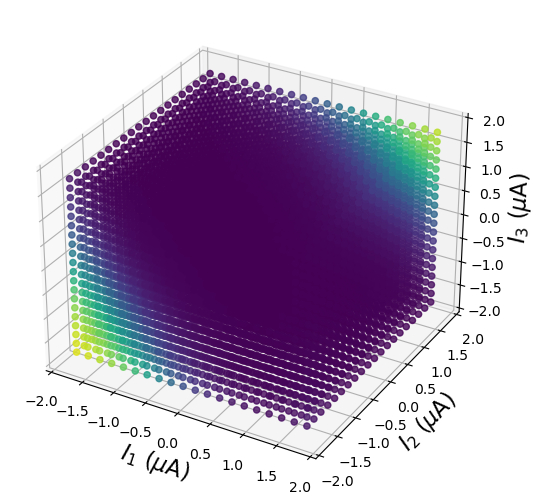

81 3


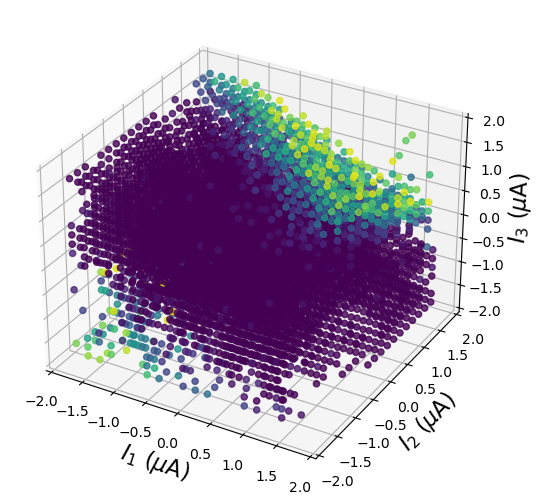

[[ -8.81667179  -1.91763916  -1.97313691  -2.37698283]
 [-11.35449955   2.79272525   3.25639709   5.71737652]]


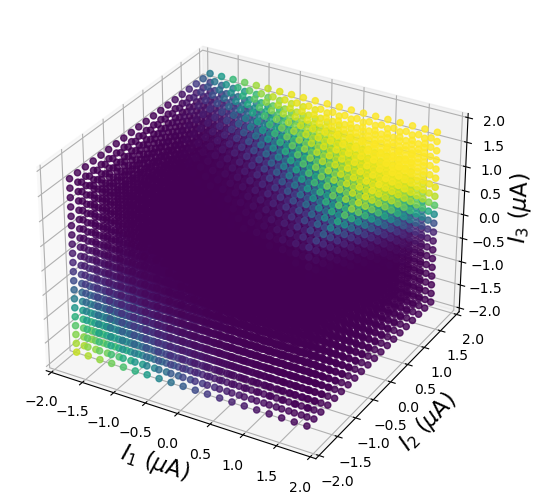

85 1


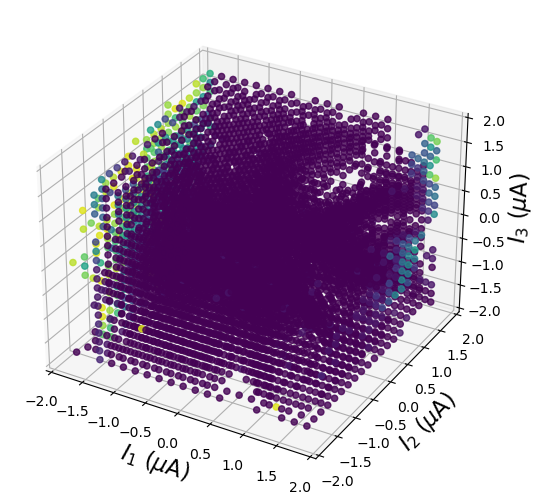

[[-12.06893499   4.84000333   1.04262053   0.23450655]
 [-20.57342194 -12.34405798  -1.2873104    0.85862849]]


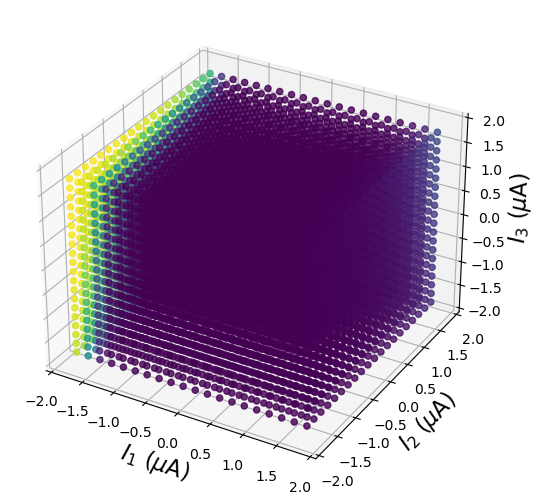

85 3


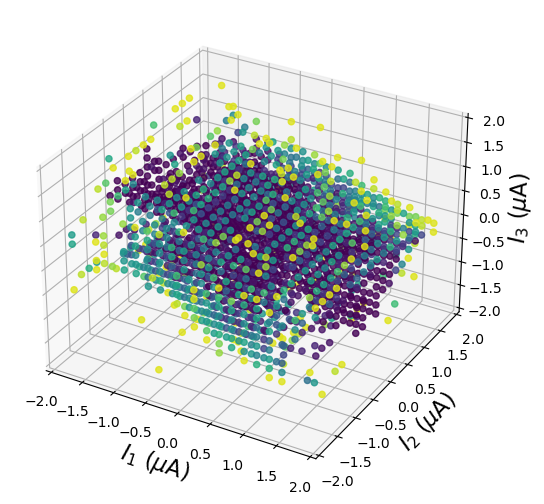

[[-11.01973393   0.79124673   6.306611    -2.85568075]
 [ -5.98518703  -2.17394828   0.03611015  -9.21036267]
 [ -8.81954266  -0.74892085  -5.55566098   1.4114892 ]
 [ -8.87061577   3.3363955    1.04961311  11.19897222]]


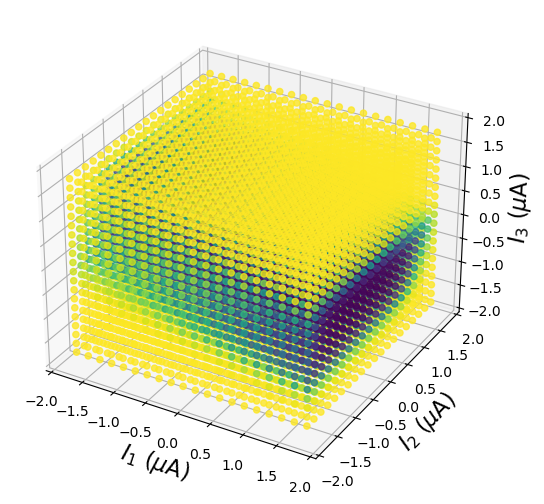

89 1


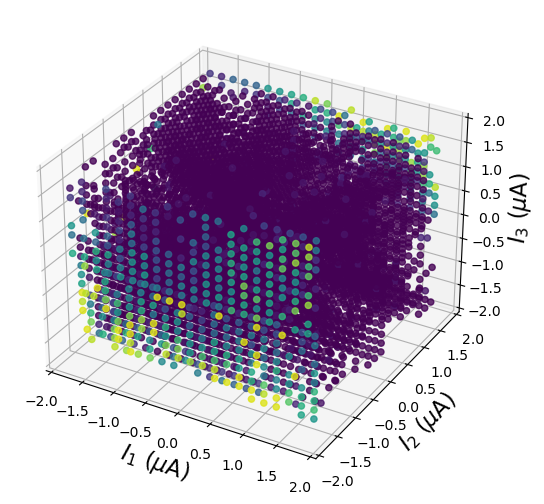

[[-2.17724418e+01  1.85704274e-02 -1.28511782e+01 -1.63205013e+00]
 [-3.32236748e+01  2.35824452e+00  1.55548770e+01  3.96294442e+00]
 [-6.01646076e+00 -7.76081133e-01  1.02200622e-01  1.53638474e-01]]


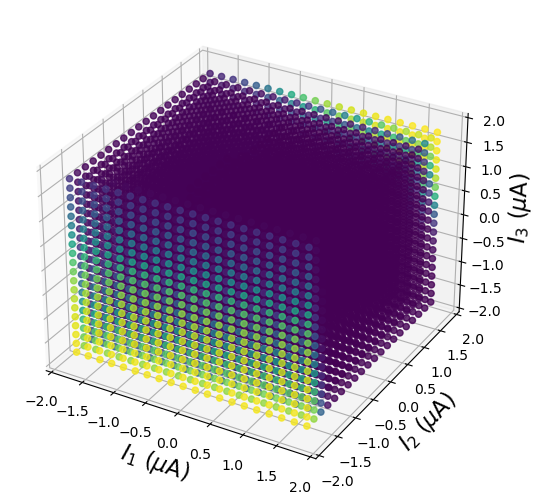

90 1


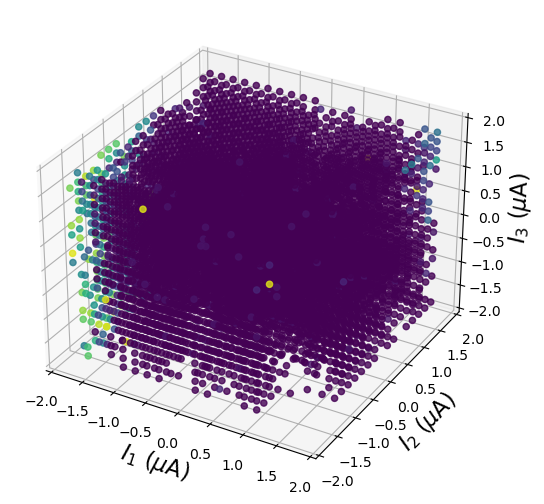

[[ -7.26865608   1.28658736   0.55589725   0.75515451]
 [-20.85814811 -10.64372554  -2.13276931  -0.20170812]]


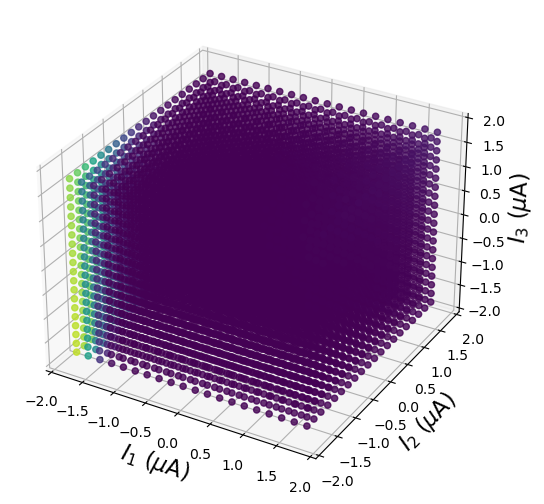

107 1


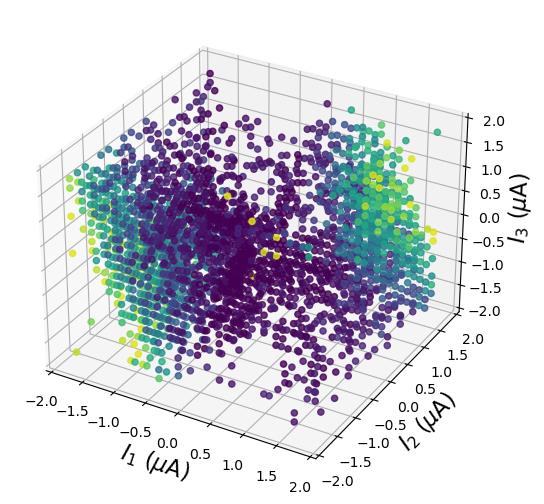

[[-5.29078277  2.62972672  0.94929478  1.06329988]
 [-5.62950755 -3.31169118 -1.14878584 -1.12292471]]


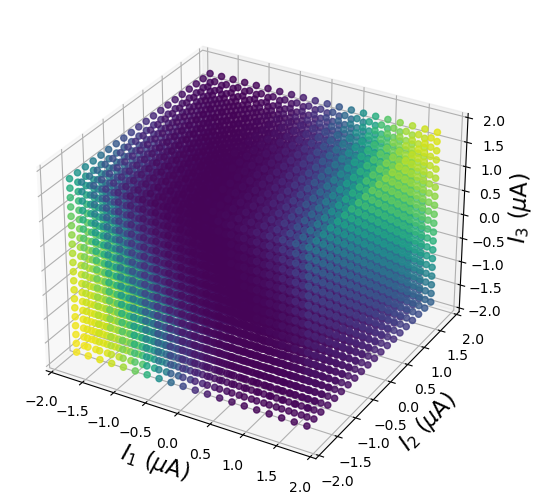

292 2


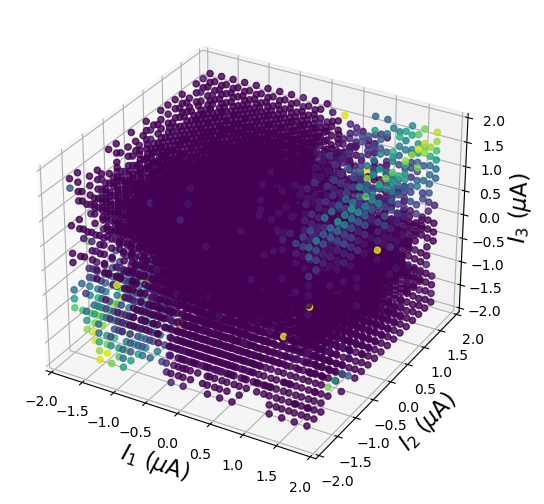

/Volumes/Lab/Users/praful/multielectrode/multielec_src/fitting.py:291: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))


[[-10.96820504  -4.49613441  -0.58032585  -2.86907531]
 [ -9.27321558   3.19121008   0.69044712   2.1187274 ]]


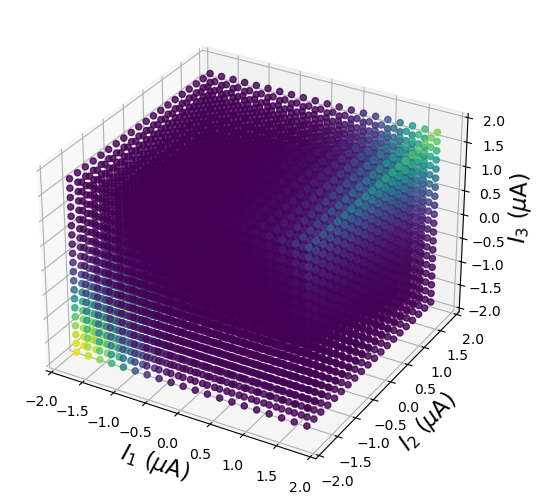

In [2]:
GSORT_BASE = "/Volumes/Scratch/Analysis"
ANALYSIS_BASE = "/Volumes/Analysis"
dataset = "2020-10-18-0"
wnoise = "kilosort_data000/data000"
spont_limit = 0.2
min_active_inds = 200
min_clean_inds = 175
ms = [1, 2, 3, 4, 5]
slope_bound = 20
zero_prob = 0.01

estim_neg = "data003/data003-all"

outpath = os.path.join(GSORT_BASE, dataset, estim_neg, wnoise)
electrical_path = os.path.join(ANALYSIS_BASE, dataset, estim_neg)
parameters = loadmat(os.path.join(outpath, 'parameters.mat'))

cells = parameters['cells'].flatten()
num_cells = len(cells)
num_patterns = max(parameters['patterns'].flatten())
num_movies = parameters['movies'].flatten()[0]

all_probs = np.nan_to_num(np.array(np.memmap(os.path.join(outpath, 'init_probs.dat'),
                                            mode='r',shape=(num_cells, num_patterns, num_movies), dtype='float32')))
trials = np.array(np.memmap(os.path.join(outpath, 'trial.dat'),mode='r',shape=(num_patterns, num_movies), dtype='int16'), dtype=int)
amps = np.array([mutils.get_stim_amps_newlv(electrical_path, 1)] * len(trials))
probs_pred_true = np.zeros(all_probs.shape)
params_true_array = np.zeros((all_probs.shape[0], all_probs.shape[1]), dtype=object)

for i in range(len(all_probs)):
    for j in range(len(all_probs[i])):
        if len(np.where(all_probs[i][j] > spont_limit)[0]) >= min_active_inds:
            print(cells[i], j+1)
            clean_inds = mutils.triplet_cleaning(amps[j], all_probs[i][j], trials[j],
                                                 return_inds=True, dist_thr=0.15)

            above_spont = np.where(all_probs[i][j][clean_inds] >= spont_limit)[0]
            if len(above_spont) >= min_clean_inds:
                fig = plt.figure()
                fig.clear()
                ax = Axes3D(fig, auto_add_to_figure=False)
                fig.add_axes(ax)
                plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
                plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
                plt.xlim(-2, 2)
                plt.ylim(-2, 2)
                ax.set_zlim(-2, 2)
                ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

                scat = ax.scatter(amps[j][clean_inds, 0], 
                                    amps[j][clean_inds, 1],
                                    amps[j][clean_inds, 2], marker='o', 
                                    c=all_probs[i][j][clean_inds], s=20, alpha=0.8, vmin=0, vmax=1)
                plt.show()

                w_inits = []
                for m in ms:
                    w_init = np.array(np.random.normal(size=(m, amps[j].shape[1]+1)))
                    z = 1 - (1 - zero_prob)**(1/len(w_init))
                    w_init[:, 0] = np.clip(w_init[:, 0], None, np.log(z/(1-z)))
                    w_init[:, 1:] = np.clip(w_init[:, 1:], -slope_bound, slope_bound)
                    w_inits.append(w_init)

                X, probs, T = deepcopy(amps[j][clean_inds]), deepcopy(all_probs[i][j][clean_inds]), deepcopy(trials[j][clean_inds])
                params_true, _, _ = fitting.fit_surface_CV(X, probs, T, w_inits)

                print(params_true)
                probs_pred_true[i][j] = fitting.sigmoidND_nonlinear(
                                                            sm.add_constant(amps[j], has_constant='add'), 
                                                            params_true)
                params_true_array[i][j] = params_true

                fig = plt.figure(2)
                fig.clear()
                ax = Axes3D(fig, auto_add_to_figure=False)
                fig.add_axes(ax)
                plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
                plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
                plt.xlim(-2, 2)
                plt.ylim(-2, 2)
                ax.set_zlim(-2, 2)
                ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

                scat = ax.scatter(amps[j][:, 0], 
                                    amps[j][:, 1],
                                    amps[j][:, 2], marker='o', 
                                    c=probs_pred_true[i][j], s=20, alpha=0.8, vmin=0, vmax=1)
                plt.show()

                input()